In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [3]:
import pandas as pd
train_df=pd.read_csv(r'/kaggle/input/playground-series-s4e1/train.csv')
test_df=pd.read_csv(r'/kaggle/input/playground-series-s4e1/test.csv')
pd.options.display.max_columns=None


In [4]:
y=train_df['Exited']
train_df.drop('Exited',axis=1,inplace=True)

## Combining train and test datasets

In [5]:
df=pd.concat([train_df,test_df],ignore_index=True)
df.set_index('id', inplace=True)
for i in [train_df,test_df,df]:
    print(i.shape)

(165034, 13)
(110023, 13)
(275057, 12)


In [6]:
categorical_features = df.select_dtypes(include=['object']).columns
binary_numeric_features = [col for col in df.columns if df[col].nunique() == 2 and df[col].dtype in ['int64', 'float64']]
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.difference(binary_numeric_features)
print("Categorical features:\n", categorical_features,"\n\nBinary features with number values:\n", binary_numeric_features,"\n\nNumerical features:\n", numerical_features)

Categorical features:
 Index(['Surname', 'Geography', 'Gender'], dtype='object') 

Binary features with number values:
 ['HasCrCard', 'IsActiveMember'] 

Numerical features:
 Index(['Age', 'Balance', 'CreditScore', 'CustomerId', 'EstimatedSalary',
       'NumOfProducts', 'Tenure'],
      dtype='object')


### Dealing with categorical features 

In [7]:
for feature in categorical_features:
    print(f'{feature}: {df[feature].unique()}')

Surname: ['Okwudilichukwu' 'Okwudiliolisa' 'Hsueh' ... 'Lindeman' 'Horrocks' 'Eve']
Geography: ['France' 'Spain' 'Germany']
Gender: ['Male' 'Female']


#### Dropping unnecessary columns

In [8]:
df.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary'],
      dtype='object')

In [9]:
df1=df.drop(['Surname'],axis=1)

In [10]:
# Apply one-hot encoding to categorical features
df2 = pd.get_dummies(df1, columns=['Geography','Gender']).astype(int)

df2.columns


Index(['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_Female', 'Gender_Male'],
      dtype='object')

In [11]:
df2.Geography_Germany.value_counts()


Geography_Germany
0    217512
1     57545
Name: count, dtype: int64

## Analyzing skewness of binary features


In [12]:
for feature in binary_numeric_features:
    print(feature)
    a=df[feature].value_counts()
    tot=sum(a)
    for i in range(len(a)):
        print(f'Class {i}: {int(a[i]/tot*100)}%')

HasCrCard
Class 0: 24%
Class 1: 75%
IsActiveMember
Class 0: 50%
Class 1: 49%


## Numerical features

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(10,5)})
for feature in numerical_features:
    sns.histplot(df2[feature],kde=True)
    print(df2[feature].mean())
    plt.show()

In [14]:
df3=df2.drop(['CustomerId'],axis=1)
df3.head()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
id,,,,,,,,,,,,,
0,668,33,3,0,2,1,0,181449,1,0,0,0,1
1,627,33,1,0,2,1,1,49503,1,0,0,0,1
2,678,40,10,0,2,1,0,184866,1,0,0,0,1
3,581,34,2,148882,1,1,1,84560,1,0,0,0,1
4,716,33,5,0,2,1,1,15068,0,0,1,0,1


## Feature Engineering

In [15]:
def getFeats(df):
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Germany_Male']=df['Geography_Germany'] * df['Gender_Male']
    df['Germany_Female']=df['Geography_Germany'] * df['Gender_Female']
    df['Spain_Female']=df['Geography_Spain'] * df['Gender_Female']
    df['France_Female']=df['Geography_France'] * df['Gender_Female']
    df.drop(['Geography_France','Geography_Germany','Geography_Spain','Gender_Female','Gender_Male'],axis=1)
    return df

In [16]:
df4=getFeats(df3)
df4.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,IsSenior,IsActive_by_CreditCard,Germany_Male,Germany_Female,Spain_Female,France_Female
id,,,,,,,,,,,,,,,,,,,
0,668,33,3,0,2,1,0,181449,1,0,0,0,1,0,0,0,0,0,0
1,627,33,1,0,2,1,1,49503,1,0,0,0,1,0,1,0,0,0,0
2,678,40,10,0,2,1,0,184866,1,0,0,0,1,0,0,0,0,0,0
3,581,34,2,148882,1,1,1,84560,1,0,0,0,1,0,1,0,0,0,0
4,716,33,5,0,2,1,1,15068,0,0,1,0,1,0,1,0,0,0,0


# Scaling data

In [17]:
# from sklearn.preprocessing import StandardScaler

# columns_to_scale = ['Age', 'CreditScore','Balance'] #
# data_to_scale = df4[columns_to_scale]

# # Initialize the StandardScaler
# scaler = StandardScaler()

# # Fit and transform the selected columns
# scaled_data = scaler.fit_transform(data_to_scale)

# df4[columns_to_scale] = scaled_data



In [18]:
# from sklearn.preprocessing import MinMaxScaler

# # Assuming df4 is your DataFrame
# # df4 = ...

# # Select columns 'Tenure', 'NumOfProducts', and 'EstimatedSalary' for scaling
# columns_to_scale = ['Tenure', 'NumOfProducts', 'EstimatedSalary']
# data_to_scale = df4[columns_to_scale]

# # Initialize the MinMaxScaler
# scaler = MinMaxScaler()

# # Fit and transform the selected columns
# scaled_data = scaler.fit_transform(data_to_scale)

# # Replace the original columns with the scaled values
# df4[columns_to_scale] = scaled_data




# Splitting the data into submission data and training data

In [19]:
train_final = df4.loc[:train_df.index.max(), :].copy()
test_final = df4.loc[train_df.index.max() + 1:, :].copy()

# EDA

In [20]:
a=y.value_counts()
tot=sum(a)
for i in range(len(a)):
    print(f'Class {i}: {int(a[i]/tot*100)}%')

Class 0: 78%
Class 1: 21%


In [21]:
num_rows_with_zero_balance = (train_final['Balance'] == 0).sum()
int(num_rows_with_zero_balance/df.shape[0] *100)


32

In [22]:
balance_null=train_final[train_final['Balance'] == 0]
balance_null.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male',
       'IsSenior', 'IsActive_by_CreditCard', 'Germany_Male', 'Germany_Female',
       'Spain_Female', 'France_Female'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


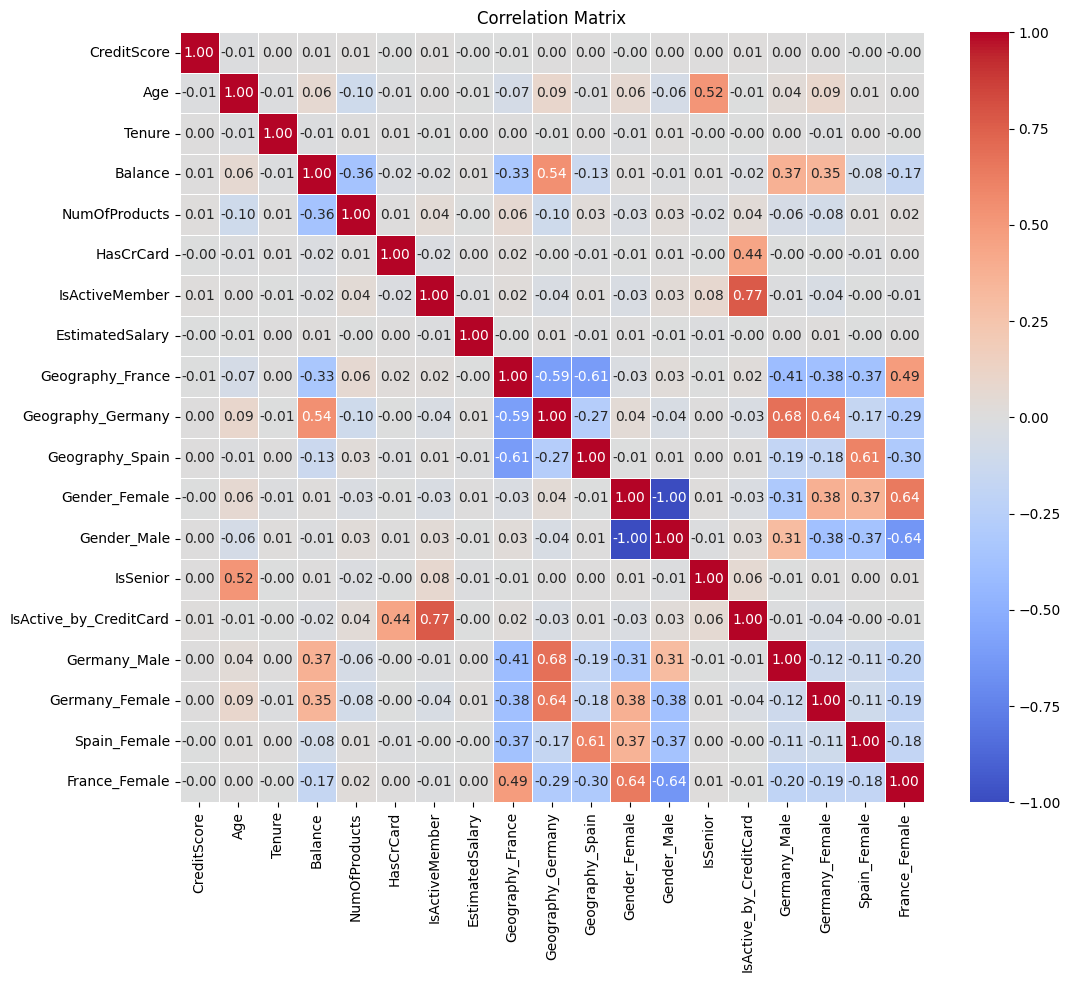

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
# Assuming train_final is your DataFrame
# train_final = ...

# Calculate the correlation matrix
correlation_matrix = train_final.corr()
# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


## Using pycaret to identify models

In [24]:
y.value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

In [25]:

# !pip install pycaret
# !pip install -q pycaret
# !pip install ipywidgets

In [26]:

# from pycaret.classification import *
# clf_setup = setup(data=train_final, target='Exited', session_id=123)
# best_model = compare_models()

## The output of pycaret is printed below


In [27]:
import pandas as pd

# Provided data
data = {
    'Model': ['lightgbm', 'catboost', 'gbc', 'xgboost', 'ada', 'rf', 'et', 'lda', 'qda', 'ridge', 'dt', 'nb', 'dummy', 'lr', 'knn', 'svm'],
    'Algorithm': ['Light Gradient Boosting Machine', 'CatBoost Classifier', 'Gradient Boosting Classifier', 'Extreme Gradient Boosting', 'Ada Boost Classifier', 'Random Forest Classifier', 'Extra Trees Classifier', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Ridge Classifier', 'Decision Tree Classifier', 'Naive Bayes', 'Dummy Classifier', 'Logistic Regression', 'K Neighbors Classifier', 'SVM - Linear Kernel'],
    'Accuracy': [0.8666, 0.8658, 0.8650, 0.8648, 0.8614, 0.8587, 0.8545, 0.8336, 0.8324, 0.8284, 0.7969, 0.7928, 0.7884, 0.7856, 0.7550, 0.5193],
    'AUC': [0.8898, 0.8890, 0.8890, 0.8861, 0.8813, 0.8739, 0.8684, 0.8189, 0.8470, 0.0000, 0.7036, 0.7709, 0.5000, 0.7147, 0.5668, 0.0000],
    'Recall': [0.5594, 0.5508, 0.5406, 0.5576, 0.5270, 0.5377, 0.5258, 0.4134, 0.5224, 0.3071, 0.5415, 0.1899, 0.0000, 0.1208, 0.1096, 0.5562],
    'Precision': [0.7465, 0.7484, 0.7517, 0.7394, 0.7433, 0.7234, 0.7115, 0.6743, 0.6243, 0.7227, 0.5193, 0.5288, 0.0000, 0.4738, 0.2905, 0.1954],
    'F1': [0.6395, 0.6346, 0.6289, 0.6357, 0.6167, 0.6169, 0.6047, 0.5125, 0.5688, 0.4309, 0.5301, 0.2794, 0.0000, 0.1924, 0.1591, 0.2753],
    'Kappa': [0.5597, 0.5547, 0.5490, 0.5547, 0.5351, 0.5325, 0.5180, 0.4191, 0.4658, 0.3487, 0.4007, 0.1887, 0.0000, 0.1165, 0.0489, 0.0464],
    'MCC': [0.5685, 0.5645, 0.5602, 0.5630, 0.5469, 0.5414, 0.5270, 0.4374, 0.4687, 0.3932, 0.4008, 0.2227, 0.0000, 0.1532, 0.0569, 0.0629],
    'TT (Sec)': [2.1760, 25.2870, 6.1040, 0.7600, 1.8450, 8.5290, 6.7510, 0.1450, 0.0800, 0.0630, 0.3890, 0.0610, 0.0490, 0.7080, 0.5030, 3.7380]
}

# Create DataFrame
df_result = pd.DataFrame(data)

# Display the DataFrame
df_result.head(15)


,Model,Algorithm,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,TT (Sec)
0,lightgbm,Light Gradient Boosting Machine,0.8666,0.8898,0.5594,0.7465,0.6395,0.5597,0.5685,2.176
1,catboost,CatBoost Classifier,0.8658,0.8890,0.5508,0.7484,0.6346,0.5547,0.5645,25.287
2,gbc,Gradient Boosting Classifier,0.8650,0.8890,0.5406,0.7517,0.6289,0.5490,0.5602,6.104
3,xgboost,Extreme Gradient Boosting,0.8648,0.8861,0.5576,0.7394,0.6357,0.5547,0.5630,0.760
4,ada,Ada Boost Classifier,0.8614,0.8813,0.5270,0.7433,0.6167,0.5351,0.5469,1.845
5,rf,Random Forest Classifier,0.8587,0.8739,0.5377,0.7234,0.6169,0.5325,0.5414,8.529
6,et,Extra Trees Classifier,0.8545,0.8684,0.5258,0.7115,0.6047,0.5180,0.5270,6.751
7,lda,Linear Discriminant Analysis,0.8336,0.8189,0.4134,0.6743,0.5125,0.4191,0.4374,0.145
8,qda,Quadratic Discriminant Analysis,0.8324,0.8470,0.5224,0.6243,0.5688,0.4658,0.4687,0.080
9,ridge,Ridge Classifier,0.8284,0.0000,0.3071,0.7227,0.4309,0.3487,0.3932,0.063


## Train test split

In [28]:
train_final=pd.concat([train_final,y],axis=1)
train_final.shape

(165034, 20)

In [29]:
from sklearn.model_selection import train_test_split

X = train_final.drop('Exited', axis=1)  # Features
y = train_final['Exited']  # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X_train.shape

(132027, 19)

In [31]:
test_final.shape

(110023, 19)

## Model training and Hyperparameter Optimization of Individual Models

### 1.Catboost

In [32]:
# import catboost
# from catboost import CatBoostClassifier, Pool
# import optuna
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score

# # Create CatBoost dataset
# train_pool = Pool(X_train, label=y_train)
# test_pool = Pool(X_test, label=y_test)

# def objective(trial):
#     # Define hyperparameters to be optimized
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 2000),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'depth': trial.suggest_int('depth', 3, 10),
#         'loss_function': 'Logloss',
#         'eval_metric': 'AUC',
#         'random_seed': 42,
#         'od_type': 'Iter',
#         'od_wait': 20,
#     }

#     # Train CatBoost model
#     model = CatBoostClassifier(**params)
#     model.fit(train_pool, eval_set=test_pool, use_best_model=False, verbose_eval=False)

#     # Get probabilities for class 1
#     probabilities = model.predict_proba(X_test)[:, 1]

#     # Calculate AUC score
#     auc_score = roc_auc_score(y_test, probabilities)

#     return auc_score

# # Create an Optuna study and optimize hyperparameters
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)  # You can adjust the number of trials

# # Get the best hyperparameters
# best_params = study.best_params
# print(f"Best Hyperparameters: {best_params}")

# # Train CatBoost model with the best hyperparameters
# best_model = CatBoostClassifier(**best_params)
# best_model.fit(train_pool, eval_set=test_pool, use_best_model=False, plot=True)

# # Get probabilities for class 1
# best_probabilities = best_model.predict_proba(X_test)[:, 1]

# # Calculate AUC score for the best model
# best_auc_score = roc_auc_score(y_test, best_probabilities)
# print(f'Best AUC Score: {best_auc_score}')

# # Plot training performance for the best model
# plt.figure(figsize=(10, 6))
# iterations = range(1, len(best_model.evals_result_['train']['AUC']) + 1)
# plt.plot(iterations, best_model.evals_result_['train']['AUC'], label='Training AUC')
# plt.plot(iterations, best_model.evals_result_['test']['AUC'], label='Test AUC')
# plt.xlabel('Iterations')
# plt.ylabel('AUC')
# plt.title('CatBoost Training Performance (Best Model)')
# plt.legend()
# plt.show()


In [33]:
best_params={'iterations': 1903, 'learning_rate': 0.02164949735080561, 'depth': 10}
best_params

{'iterations': 1903, 'learning_rate': 0.02164949735080561, 'depth': 10}

In [34]:
# import catboost
# from catboost import CatBoostClassifier, Pool
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score
# # Create CatBoost dataset
# train_pool = Pool(X_train, label=y_train)
# test_pool = Pool(X_test, label=y_test)

# # Best hyperparameters from Optuna
# best_params = {
#     'iterations': 1903, 'learning_rate': 0.02164949735080561, 'depth': 10,
#     'loss_function': 'Logloss',
#     'eval_metric': 'AUC',
#     'random_seed': 42,
#     'od_type': 'Iter',
#     'od_wait': 20,
# }

# # Train CatBoost model with the best hyperparameters
# cat_boost = CatBoostClassifier(**best_params)
# cat_boost.fit(train_pool, eval_set=test_pool, use_best_model=False, plot=True)

# # Get probabilities for class 1 using the best model
# best_probabilities = cat_boost.predict_proba(X_test)[:, 1]

# # Calculate AUC score for the best model
# best_auc_score = roc_auc_score(y_test, best_probabilities)
# print(f'Best AUC Score: {best_auc_score}')



In [35]:
# # Making predictions on the test set
# y_pred_prob = model.predict(X_test)
# y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]
# from sklearn.metrics import f1_score
# # Evaluating the model using F1 score
# f1 = f1_score(y_test, y_pred)
# f1

In [36]:
X_train.shape


(132027, 19)

### 2. LightBGM

In [37]:
best_params={'num_leaves': 184,
 'learning_rate': 0.1488292301179355,
 'feature_fraction': 0.36805005009589187,
 'bagging_fraction': 0.937208340511088,
 'bagging_freq': 4}

In [38]:
# import lightgbm as lgb
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score
# # Define hyperparameters
# params = {
#     'objective': 'binary',
#     'metric': 'auc',
#     'boosting_type': 'gbdt',
#     'num_leaves': 184,
#  'learning_rate': 0.1488292301179355,
#  'feature_fraction': 0.36805005009589187,
#  'bagging_fraction': 0.937208340511088,
#  'bagging_freq': 4,
#     'random_state': 42,
# }

# # Create LightGBM dataset
# train_data = lgb.Dataset(X_train, label=y_train)
# test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# # Train LightGBM model
# model = lgb.train(params, train_data, valid_sets=[train_data, test_data], verbose_eval=False)

# # Get probabilities for class 1
# probabilities = model.predict(X_test)

# # Calculate AUC score
# auc_score = roc_auc_score(y_test, probabilities)
# print(f'AUC Score: {auc_score}')


## Using ANN

In [39]:
X_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,IsSenior,IsActive_by_CreditCard,Germany_Male,Germany_Female,Spain_Female,France_Female
149380,679,41,9,0,2,1,1,103560,1,0,0,0,1,0,1,0,0,0,0
164766,721,46,9,115764,2,1,0,102950,1,0,0,0,1,0,0,0,0,0,0
155569,551,35,5,0,1,1,0,155394,1,0,0,0,1,0,0,0,0,0,0
124304,743,31,3,57866,2,1,1,107428,0,0,1,1,0,0,1,0,0,1,0
108008,675,28,2,0,2,1,0,134110,1,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,668,45,6,104576,1,1,0,113081,0,1,0,0,1,0,0,1,0,0,0
103694,751,43,7,0,2,1,0,88866,1,0,0,0,1,0,0,0,0,0,0
131932,753,39,7,0,2,1,0,167973,1,0,0,1,0,0,0,0,0,0,1
146867,685,48,4,0,2,1,1,24998,1,0,0,1,0,0,1,0,0,0,1


In [40]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Use StandardScaler to scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# Define the model
model = Sequential()
model.add(Dense(19, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(19, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# Train the model for 100 epochs
history = model.fit(X_train_scaled, y_train, epochs=13, validation_data=(X_test_scaled, y_test), verbose=2)



Epoch 1/13
4126/4126 - 14s - loss: 0.3596 - auc_3: 0.8560 - val_loss: 0.3338 - val_auc_3: 0.8820 - 14s/epoch - 3ms/step
Epoch 2/13
4126/4126 - 12s - loss: 0.3311 - auc_3: 0.8811 - val_loss: 0.3263 - val_auc_3: 0.8851 - 12s/epoch - 3ms/step
Epoch 3/13
4126/4126 - 12s - loss: 0.3285 - auc_3: 0.8833 - val_loss: 0.3274 - val_auc_3: 0.8866 - 12s/epoch - 3ms/step
Epoch 4/13
4126/4126 - 12s - loss: 0.3269 - auc_3: 0.8846 - val_loss: 0.3249 - val_auc_3: 0.8861 - 12s/epoch - 3ms/step
Epoch 5/13
4126/4126 - 12s - loss: 0.3259 - auc_3: 0.8853 - val_loss: 0.3215 - val_auc_3: 0.8884 - 12s/epoch - 3ms/step
Epoch 6/13
4126/4126 - 12s - loss: 0.3254 - auc_3: 0.8856 - val_loss: 0.3224 - val_auc_3: 0.8879 - 12s/epoch - 3ms/step
Epoch 7/13
4126/4126 - 12s - loss: 0.3250 - auc_3: 0.8858 - val_loss: 0.3231 - val_auc_3: 0.8877 - 12s/epoch - 3ms/step
Epoch 8/13
4126/4126 - 12s - loss: 0.3248 - auc_3: 0.8860 - val_loss: 0.3213 - val_auc_3: 0.8883 - 12s/epoch - 3ms/step
Epoch 9/13
4126/4126 - 12s - loss: 0.324

In [ ]:
model.predict(test_final)

In [ ]:
# Plot the training and test loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Training and Test Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [48]:
model2.predict(X_test)

1032/1032 [==============================] - 1s 1ms/step


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

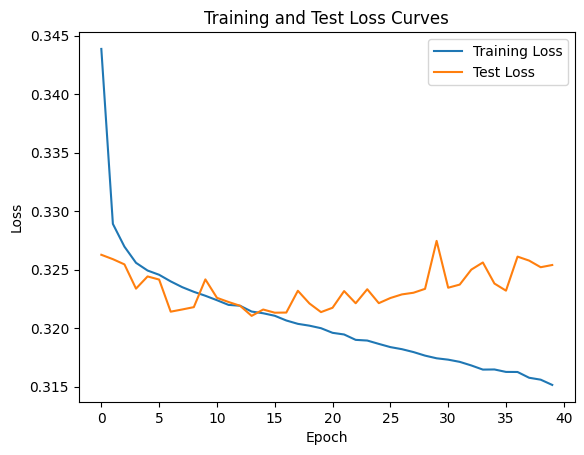

In [46]:
# Plot the training and test loss curves
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Test Loss')
plt.title('Training and Test Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Using ensemble of LightBGM and CatBoost

In [ ]:
from catboost import CatBoostClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score


# Best hyperparameters from Optuna for CatBoost
best_params_catboost = {
    'iterations': 1903,
    'learning_rate': 0.02164949735080561,
    'depth': 10,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'od_type': 'Iter',
    'od_wait': 20,
}

# Train CatBoost model with the best hyperparameters
catboost_model = CatBoostClassifier(**best_params_catboost)

# Best hyperparameters for LightGBM
best_params_lightgbm = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 184,
    'learning_rate': 0.1488292301179355,
    'feature_fraction': 0.36805005009589187,
    'bagging_fraction': 0.937208340511088,
    'bagging_freq': 4,
    'random_state': 42,
}

# Define LightGBM model with the best hyperparameters
lgb_model = lgb.LGBMClassifier(**best_params_lightgbm)

# Best hyperparameters for XGBoost
best_params_xgboost = {
    'n_estimators': 225,
    'learning_rate': 0.06721868993027282,
    'max_depth': 8,
    'subsample': 0.9788006898427435,
    'random_state': 42,
}

# Train XGBoost model
# xgboost_model = XGBClassifier(**best_params_xgboost)
# xgboost_model.fit(X_train, y_train)




In [ ]:
# from sklearn.model_selection import StratifiedKFold


# # Specify the number of folds (e.g., 5)
# num_folds = 8

# # Initialize StratifiedKFold
# stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# # Iterate through the splits
# for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X_train, y_train)):
#     # Create training and validation sets for this fold
#     X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
#     y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
#     catboost_model.fit(X_train, y_train)
#     lgb_model.fit(X_train, y_train)
    
#     print(f"Fold {fold + 1}: Training samples - {len(train_index)}, Validation samples - {len(val_index)}")



In [ ]:
def ensemble_predict_proba(models, weights, X):
    predictions_proba = [model.predict_proba(X)[:, 1] for model in models]
    weighted_predictions_proba = sum(w * p for w, p in zip(weights, predictions_proba))
    return weighted_predictions_proba

# Usage:
ensemble_pred_proba_test = ensemble_predict_proba([catboost_model, lgb_model], weights, X_test)

# Display the probabilities from the ensemble model on the test set
print("Ensemble Model Probabilities on Test Set:", ensemble_pred_proba_test)


In [ ]:
# Calculate F1 scores for each model
f1_catboost = f1_score(y_test, catboost_model.predict(X_test))
f1_lgb = f1_score(y_test, lgb_model.predict(X_test))

# Create a weighted ensemble using F1 scores as weights
weights = [f1_catboost, f1_lgb]
weights /= sum(weights)  # Normalize weights to sum to 1
# Display the probabilities from the ensemble model

# Make predictions on the validation set for each model
catboost_pred_proba = catboost_model.predict_proba(X_test)[:, 1]
lgb_pred_proba = lgb_model.predict_proba(X_test)[:, 1]
# xgboost_pred_proba = xgboost_model.predict_proba(X_test)[:, 1]
# Weighted ensemble prediction returning probabilities
ensemble_pred_proba = (
    weights[0] * catboost_pred_proba +
    weights[1] * lgb_pred_proba
   
)

print("Ensemble Model Probabilities:", ensemble_pred_proba)



## Making submission file

In [ ]:
probabilities = ensemble_predict_proba([catboost_model, lgb_model], weights, test_final)
len(probabilities)

In [51]:
probabilities = model.predict(test_final)
len(probabilities)

3439/3439 [==============================] - 5s 1ms/step


110023

In [57]:
probabilities=probabilities.tolist()

In [58]:
import pandas as pd
subm = pd.DataFrame({'id': test_final.index, 'Exited': probabilities})

In [59]:
csv_file_path = 'submission3_1.csv'

# Export the DataFrame to a CSV file
subm.to_csv(csv_file_path, index=False)
